# Reptrix Tutorial 

In this tutorial, we show how to use reptrix to assess representations of a model pretrained using self-supervised learning. 

Here we use the [STL-10](https://cs.stanford.edu/~acoates/stl10/) dataset, which contains 10 classes of images. 

We will use the [Barlow Twins](https://arxiv.org/abs/2103.03230), and [DINO](https://arxiv.org/abs/2104.14294) models as examples.

To assess the quality of the learned representations, we will use various metrics, including:

- [**Alpha**](https://proceedings.neurips.cc/paper_files/paper/2022/hash/70596d70542c51c8d9b4e423f4bf2736-Abstract-Conference.html): This metric computes the eigenvalues of the covariance matrix of the representations and fits a power-law distribution to them. The exponent of the power-law distribution is called the alpha exponent, which measures the heavy-tailedness of the distribution. A lower alpha exponent indicates that the representations are more discriminative.

- [**RankMe**](https://proceedings.mlr.press/v202/garrido23a): This metric computes the rank of the covariance matrix of the representations. A higher rank indicates representations of higher capacity.

- [**LiDAR**](https://openreview.net/forum?id=f3g5XpL9Kb): This metric computes the rank of the Linear Discriminant Analysis (LDA) matrix constructed using representations of augmented versions of images. A higher rank indicates representations of higher discriminability.


We will compute these metrics using the Reptrix library, which provides a convenient interface for representation analysis. Let's dive into the code and explore the evaluation process in detail.



### Import Libraries, get device and define feature extraction function

In [1]:
import torch
import torchvision
from tqdm import tqdm
from reptrix import alpha, rankme, lidar
import reptrix
import time

Get the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Function to get the features of from the pretrained encoder model using a dataset. 

In [3]:
def get_features(encoder_function, dataloader, transform=None, num_augmentations=10):
    # Loop over the dataset and collect the representations
    all_features = []

    # Loop over the dataset and collect the representations
    for i, data in enumerate(tqdm(dataloader, 0)):
        inputs, _ = data
        # apply multiple augmentations for each image
        if transform:
            inputs = torch.cat([transform(inputs) for _ in range(num_augmentations)], dim=0)
        with torch.no_grad():
            features = encoder_function(inputs.to(device))
        if transform:
            # put the augmentations in an additonal dimension
            features = features.reshape(num_augmentations, -1, features.shape[1]).transpose(1,0)
        all_features.append(features)
            
            
    # Concatenate all the features
    all_features = torch.cat(all_features, dim=0)
    return all_features

## Get the STL-10 dataset 

In [4]:
transform_to_tensor = torchvision.transforms.ToTensor()

STL_MEAN = (0.4467, 0.4398, 0.4066)
STL_STD = (0.2242, 0.2215, 0.2239)
transform_base = torchvision.transforms.Normalize(STL_MEAN, STL_STD)

# Define additional SSL transformations for the Lidar metric evaluation
transform_ssl = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.RandomResizedCrop(
        96, scale=(0.8, 1.0), 
        ratio=(0.75, (4/3)), 
        interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    torchvision.transforms.Normalize(STL_MEAN, STL_STD)
])
    
dataset_folder = '/network/datasets/stl10.var/stl10_torchvision'
# Get the STL10 test dataset to measure the quality of the representations learned by the model
# testset = torchvision.datasets.STL10(root='./data', split='test', download=False, transform=transform)
testset = torchvision.datasets.STL10(root=dataset_folder, split='test', download=False, transform=transform_to_tensor)

# Define a dataloader to load the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

## Load the pretrained models, extract the features and compute the metrics

### 1. ResNet50 encoder trained with Barlow Twins

In this section, we will evaluate the representations learned by an encoder trained with the Barlow Twins method.

In [5]:
# Define a resnet encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Barlow Twins
encoder = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
# Remove the final fully connected layer so that the model outputs the 2048 feature vector
encoder = torch.nn.Sequential(*(list(encoder.children())[:-1]))

Using cache found in /home/mila/a/arnab.mondal/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/mila/a/arnab.mondal/.conda/envs/reptrix/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/a/arnab.mondal/.conda/envs/reptrix/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()

all_representations = get_features(encoder, testloader, transform=transform_base, num_augmentations=1)

100%|██████████| 32/32 [00:03<00:00,  9.16it/s]


In [7]:
all_representations.shape

torch.Size([8000, 1, 2048])

In [8]:
start_time = time.time()
metric_alpha = alpha.get_alpha(all_representations)
alpha_time = time.time()
metric_rankme = rankme.get_rankme(all_representations)
rankme_time = time.time()
alpha_compute_time = alpha_time - start_time
rankme_compute_time = rankme_time - alpha_time

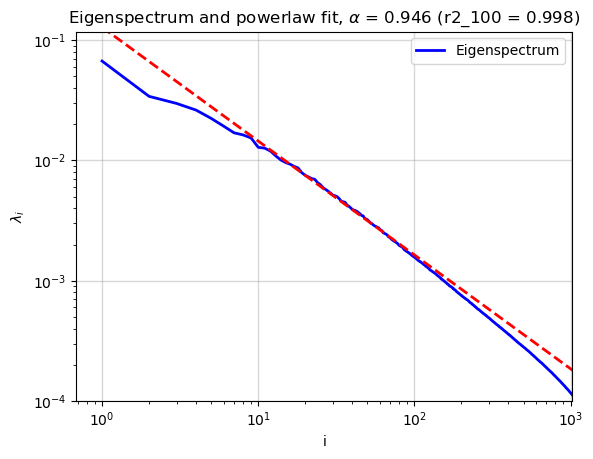

In [9]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)

In [10]:
# Get features of all the augmentations for LiDAR metric evaluation
num_augmentations = 10
all_representations_ssl = get_features(encoder.forward, testloader, transform=transform_ssl, num_augmentations=num_augmentations)

num_samples = all_representations_ssl.shape[0] // num_augmentations

# Randomly sample num_samples number of samples from the all_representations_ssl
ramdom_sample_index = torch.randperm(all_representations_ssl.shape[0])[:num_samples]
subsampled_representations_ssl = all_representations_ssl[ramdom_sample_index]

# Get the Lidar metric
start_time = time.time()
lidar_metric = lidar.get_lidar(subsampled_representations_ssl, num_samples, num_augmentations, del_sigma_augs=0.001)
lidar_time = time.time()
lidar_compute_time = lidar_time - start_time


# For lidar metric evaluation, we need to use the SSL transformations over the test dataset

print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}, LiDAR: {lidar_metric}')
print(f'Compute time for different metrics: Alpha: {alpha_compute_time:.3f}s, Rankme: {rankme_compute_time:.3f}s, LiDAR: {lidar_compute_time:.3f}s')

  0%|          | 0/32 [00:00<?, ?it/s]/network/scratch/g/ghosharn/conda_envs/ffcv_ssl_fastssl/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 32/32 [01:31<00:00,  2.87s/it]


Values of different metrics: Alpha: 0.9461134930695289, Rankme: 364.6830749511719, LiDAR: 102.7093505859375
Compute time for different metrics: Alpha: 2.400s, Rankme: 2.364s, LiDAR: 7.929s


### 2. Vit Encoder trained with DINO

In [11]:
# Define a vit encoder using pytorch where you can load the weights from a pre-trained model
# We will use encoder that is trained using Dino
encoder = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Using cache found in /home/mila/g/ghosharn/.cache/torch/hub/facebookresearch_dino_main


In [12]:
# Move the model to the device
encoder = encoder.to(device)

# Set the model to evaluation mode
encoder.eval()
    
all_representations = get_features(encoder.forward, testloader, transform=transform_base, num_augmentations=1)

print('Shape of the representations:', all_representations.shape) 

100%|██████████| 32/32 [00:02<00:00, 10.68it/s]

Shape of the representations: torch.Size([8000, 1, 384])


In [13]:
start_time = time.time()
metric_alpha = alpha.get_alpha(all_representations)
alpha_time = time.time()
metric_rankme = rankme.get_rankme(all_representations)
rankme_time = time.time()
alpha_compute_time = alpha_time - start_time
rankme_compute_time = rankme_time - alpha_time

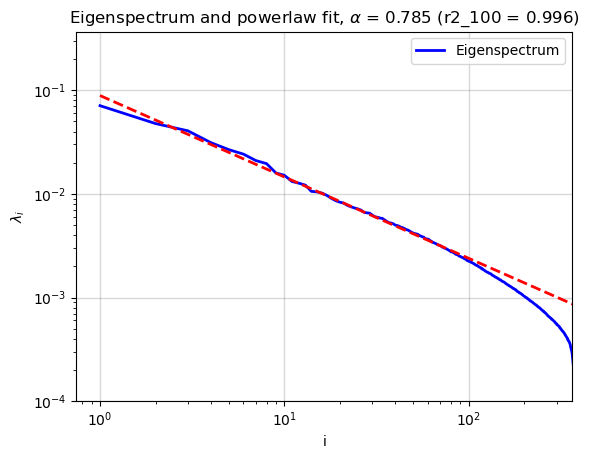

In [14]:
# Plot the eigenspectrum and the powerlaw fit
eigenspectrum = reptrix.utils.get_eigenspectrum(all_representations.cpu())

# reptrix.utils.plot_eigenspectrum(eigenspectrum)
reptrix.alpha.plot_powerlaw(eigenspectrum, metric_alpha)

In [15]:
# Get features of all the augmentations for LiDAR metric evaluation
num_augmentations = 10
all_representations_ssl = get_features(encoder.forward, testloader, transform=transform_ssl, num_augmentations=num_augmentations)

print("Shape of the representations after SSL transformations:", all_representations_ssl.shape)

num_samples = all_representations_ssl.shape[0] // num_augmentations

# Randomly sample num_samples number of samples from the all_representations_ssl
ramdom_sample_index = torch.randperm(all_representations_ssl.shape[0])[:num_samples]
subsampled_representations_ssl = all_representations_ssl[ramdom_sample_index]

# Get the Lidar metric
start_time = time.time()
lidar_metric = lidar.get_lidar(subsampled_representations_ssl, num_samples, num_augmentations, del_sigma_augs=0.001)
lidar_time = time.time()
lidar_compute_time = lidar_time - start_time

# For lidar metric evaluation, we need to use the SSL transformations over the test dataset

print(f'Values of different metrics: Alpha: {metric_alpha[0]}, Rankme: {metric_rankme}, LiDAR: {lidar_metric}')
print(f'Compute time for different metrics: Alpha: {alpha_compute_time:.3f}s, Rankme: {rankme_compute_time:.3f}s, LiDAR: {lidar_compute_time:.3f}s')

  0%|          | 0/32 [00:00<?, ?it/s]/network/scratch/g/ghosharn/conda_envs/ffcv_ssl_fastssl/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 32/32 [01:31<00:00,  2.87s/it]


Shape of the representations after SSL transformations: torch.Size([8000, 10, 384])
Values of different metrics: Alpha: 0.7854639552258638, Rankme: 156.16427612304688, LiDAR: 15.42029094696045
Compute time for different metrics: Alpha: 0.137s, Rankme: 0.091s, LiDAR: 0.162s
